# Simulation Case-Study: Neuroscience

This notebook implements and analyses the behaviours of biological functions associated with neuron and cortical activity. It is self-contained with the implementation, simulation, and further analysis as a single methodological process. The simulations that are conducted for this case-study are described below. Biophysical behaviour will be sourced from Izhikevich's 2003 _Simple Model of Spiking Neurons_, IEEE Transactions On Neural Networks, 14(6), p.1569-1572.

1. **Neuron Spiking Behaviour** - Modelling the activations and spiking behaviour of typical neuron conditions.
2. **Cortex Synchronisation** - Modelling a random network of neurons and resultant cortical synchronisation for firings.
3. **Synapse Current Transfer** - Modelling a synapse and current flow when neurons fire.

Further ablation studies are performed to further inquiry into unique simulation behaviours.

In [706]:
import enum
import warnings
import itertools
from dataclasses import dataclass, field

import tqdm
import numpy as np
import pandas as pd
import mplcyberpunk
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [707]:
# Plotting style
plt.style.use(["seaborn-v0_8-notebook", "cyberpunk"])
plt.rcParams["figure.figsize"] = (18, 9)

In [708]:
# Simulation defaults
SIMULATION_TOTAL_TIME_MS: int = 1000
SIMULATION_DELTA_STEP_MS: float = 0.1
SIMULATION_STEPS: int = int(SIMULATION_TOTAL_TIME_MS / SIMULATION_DELTA_STEP_MS)

## Simulation 1: Neuron Spiking Behaviour

The goal of this simulation is to implement Izhikevich's original neuron conditions to reproduce the behaviours of the different types of neurons: Regular Spiking, Intrinsically Bursting, Chattering, Fast Spiking, Low-Threshold Spiking, Thalamo-Cortical, and Resonator. Constant neuron definitions are constructed so the behaviour of each is consistent. There are several variables and constants to consider:

- $a$: Time-scale for the neuron recovery variable.
- $b$: Sensitivity for the neuron recovery variable.
- $c$: Reset value for the membrane potential.
- $d$: Reset value for the recovery variable.
- $\hat{v}$: Simulation variable for the neuron membrane potential.
- $\hat{u}$: Simulation variable for the neuron recovery variable.

This simulation uses first-order differential equations for the simulated $\hat{v}$ and $\hat{u}$. The update function is performed for a given time-step delta as follows:

$$
\begin{align}
    \frac{d\hat{v}}{dt} &= 
        \begin{cases}
            c & \hat{v} \geq 30 \\
            0.04\hat{v}^2 + 5\hat{v} + 140 - \hat{u} + I & \text{otherwise}
        \end{cases} \\
    \frac{d\hat{u}}{dt} &= 
        \begin{cases}
            d + \hat{u} & \hat{v} \geq 30 \\
            a ( b\hat{v}-\hat{u}) & otherwise
        \end{cases} 
\end{align}
$$

Based on this simulation, the following figure describes the expected behaviours for each neuron class. For reference, input current has step-wise differences of $I=10$, variable resting membrane potential which will be denoted $r$, with varying stimulation periods and spikes.

<br>

<center>
<img src="./imgs/neuron-spiking.png" alt="expected neuron spiking behaviour" width="80%"/>
</center>



### Constructing a Neuron Abstraction


There will be explicit consant instances of neurons that are biologically accurate according to the reference source. There are a total of 7 neurons to consider (one of which has 2 behaviours to monitor) which are defined around a class definition with the aforementioned attributes.

- Regular Spiking
- Intrinsically Bursting
- Chattering
- Fast Spiking
- Low-Threshold Spiking
- Thalamo-Cortical (Normal)
- Thalamo-Cortical (Burst)
- Resonator

<br>

<center>
<img src="./imgs/neuron-params.png" alt="expected neuron parameters" width="80%"/>
</center>

In [709]:
class NeuronClass(enum.Enum):
    RS = ("Regular Spiking", "Excitatory")
    IB = ("Intrinsically Bursting", "Excitatory")
    CH = ("Chattering", "Excitatory")
    FS = ("Fast Spiking", "Inhibitory")
    LTS = ("Low-Threshold Spiking", "Inhibitory")
    TCN = ("Thalamo-Cortical (Normal)", "Other")
    TCB = ("Thalamo-Cortical (Burst)", "Other")
    RZ = ("Resonator", "Other")

@dataclass(frozen=True, slots=True, eq=True)
class Neuron:
    """
    Neurons are constant abstractions for the neuroscience case-study. The different
    parameters are associated with the individual behaviours of each kind which impacts
    simulated membrane potential` and recovery variable changes over time.
    """

    dclass: NeuronClass = field(metadata={"desc": "Neuron type."})
    a: float = field(metadata={"desc": "Time-scale for the neuron recovery variable."})
    b: float = field(metadata={"desc": "Sensitivity for the neuron recovery variable."})
    c: float = field(metadata={"desc": "Reset value for the membrane potential."})
    d: float = field(metadata={"desc": "Reset value for the recovery variable."})
    r: float = field(metadata={"desc": "Resting value for the membrane potential."})

In [710]:
NEURONS: dict[NeuronClass, Neuron] =  {
    NeuronClass.RS:  Neuron(NeuronClass.RS,  a=0.02, b=0.20, c=-65, d=8.00, r=-70.0),
    NeuronClass.IB:  Neuron(NeuronClass.IB,  a=0.02, b=0.20, c=-55, d=4.00, r=-70.0),
    NeuronClass.CH:  Neuron(NeuronClass.CH,  a=0.02, b=0.20, c=-50, d=2.00, r=-50.0),
    NeuronClass.FS:  Neuron(NeuronClass.FS,  a=0.10, b=0.20, c=-65, d=2.00, r=-70.0),
    NeuronClass.LTS: Neuron(NeuronClass.LTS, a=0.02, b=0.25, c=-65, d=2.00, r=-65.0),
    NeuronClass.TCN: Neuron(NeuronClass.TCN, a=0.02, b=0.25, c=-65, d=0.05, r=-63.0),
    NeuronClass.TCB: Neuron(NeuronClass.TCB, a=0.02, b=0.25, c=-65, d=0.05, r=-87.0),
    NeuronClass.RZ:  Neuron(NeuronClass.RZ,  a=0.10, b=0.26, c=-65, d=2.00, r=-65.0),
}

Text(0.5, 0.98, 'Individual Neuron Parameter Map')

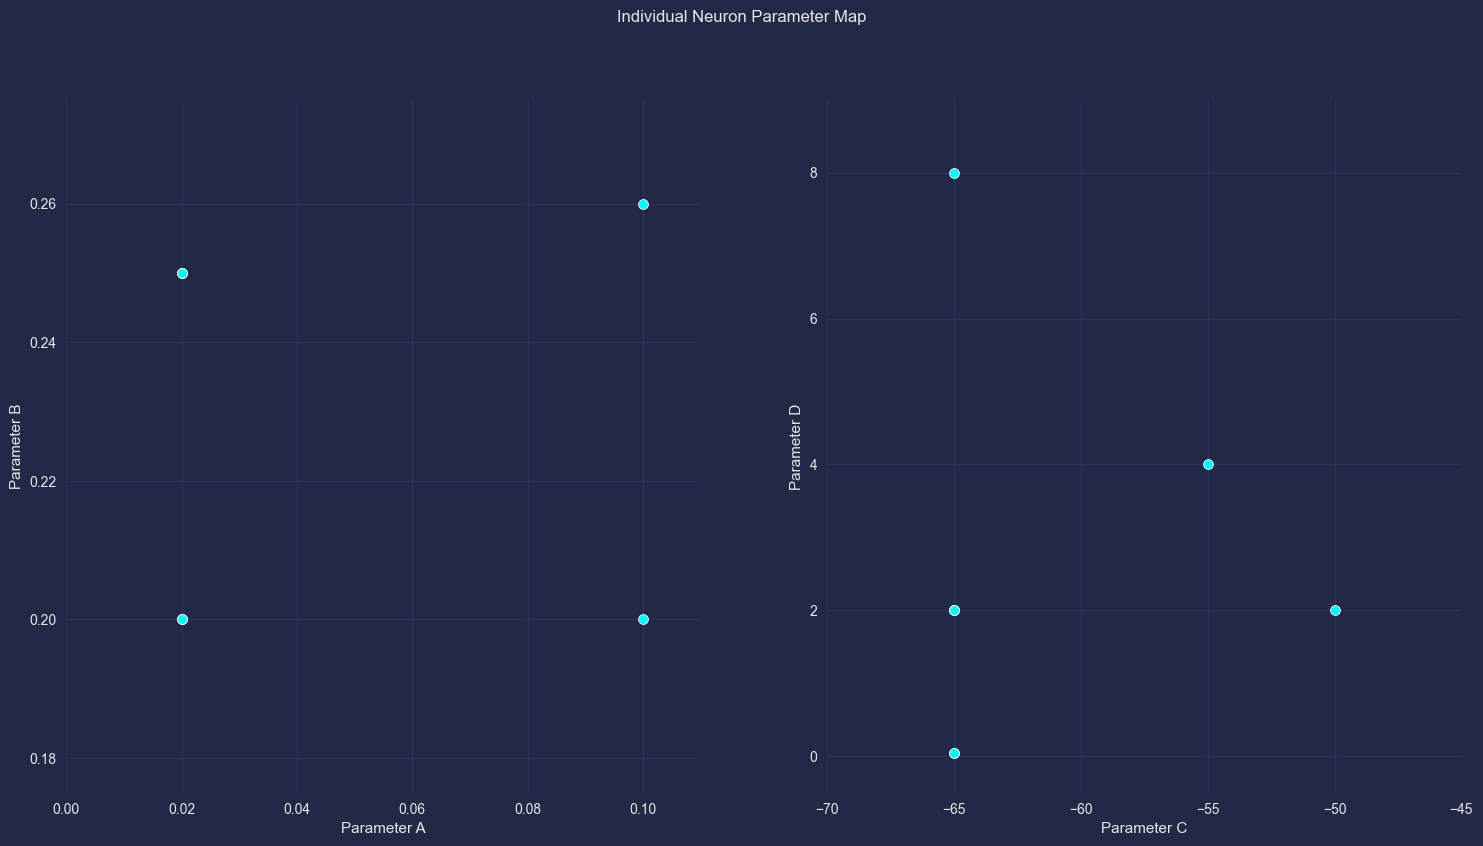

In [711]:
# Plot neuron parameters
neuron_a = [neuron.a for neuron in NEURONS.values()]
neuron_b = [neuron.b for neuron in NEURONS.values()]
neuron_c = [neuron.c for neuron in NEURONS.values()]
neuron_d = [neuron.d for neuron in NEURONS.values()]
fig, (axes1, axes2) = plt.subplots(ncols=2)
p1 = sns.scatterplot(x=neuron_a, y=neuron_b, ax=axes1, s=50)
p1.set_xlabel("Parameter A")
p1.set_ylabel("Parameter B")
p1.set_xlim((0, 0.11))
p1.set_ylim((0.175, 0.275))
p2 = sns.scatterplot(x=neuron_c, y=neuron_d, ax=axes2, s=50)
p2.set_xlabel("Parameter C")
p2.set_ylabel("Parameter D")
p2.set_xlim((-70, -45))
p2.set_ylim((-0.5, 9))
fig.suptitle("Individual Neuron Parameter Map")

### Constructing a Simulation 

Simulations are designed as static class functions wrapping any additional functions as static methods within this single class instance. For variability, this simulation will allow changing the simulation time and delta-step as well as a neuron input current provided as a single array of values provided at each simulation step.

In [712]:
class NeuronSpikingSimulation:
    NEURON_THRESHOLD: float = 30.0
    NEURON_INITIAL_RECOVERY_VARIABLE: float = 0.0

    @staticmethod
    def dvdt(v: float, u: float, I: float) -> float:
        """
        Update function for a time-step delta of the neuron membrane potential based on
        the previous value. 
        
        Args:
            v (float): Previously updated membrane potential.
            u (float): Previously updated recovery variable.
            I (float): Post-synaptic input current.

        Returns:
            float: New membrane potential.
        """
        return (0.04 * v**2) + (5 * v) + 140 - u + I

    @staticmethod
    def dudt(neuron: Neuron, v: float, u: float) -> float:
        """
        Update function for a time-step delta of the neuron recovery variable based on
        the previous value. 

        Args:
            neuron (Neuron): Neuron container for necessary constant parameters.
            v (float): Previously updated membrane potential.
            u (float): Previously updated recovery variable.

        Returns:
            float: Delta time-step recovery from Izhikevich's formula.
        """
        return neuron.a * (neuron.b * v - u)

    @staticmethod
    def simulate(
        neuron: Neuron, 
        I: np.ndarray, 
        simulation_total_time: int = SIMULATION_TOTAL_TIME_MS, 
        simulation_time_step: float = SIMULATION_DELTA_STEP_MS,
        factor: float = 1.0,
    ) -> pd.DataFrame:
        """
        Simulate the changing membrane potential and recovery variable for an individual
        neuron and given time-steps/input currents. 

        Args:
            neuron (Neuron): Parameterised neuron for simulating spiking behaviour.
            I (np.ndarray): Array of time-step input currents to simulate.
            simulation_total_time (int, optional): Milliseconds time. Defaults to 
                SIMULATION_TOTAL_TIME_MS.
            simulation_time_step (float, optional): Millisecond step. Defaults to 
                SIMULATION_DELTA_STEP_MS.
            factor (float, optional): Factor applied to input current. Defaults to 1.0.

        Returns:
            pd.DataFrame: DataFrame of simulation results. Rows correspond to time step
                with columns for simulation time, membrane potential, and recovery.
                
        Raises:
            AssertionError: Input current array has too few step values.        
        """
        
        # Calculate number of simulation steps
        steps = int(simulation_total_time / simulation_time_step)
        assert I.size >= steps

        # Setup containers for recording step values
        T = np.zeros(steps, dtype=np.float32)
        F = np.repeat(factor, steps)
        v_arr = np.zeros(steps, dtype=np.float32)
        u_arr = np.zeros(steps, dtype=np.float32)
        v_arr[0] = neuron.r
        u_arr[0] = neuron.r * neuron.b

        # Cycle through the simulation steps and perform updates
        desc = f"Neuron Spiking Simulation: ({neuron.dclass.value[0]})"
        for ind in tqdm.tqdm(range(1, steps), desc=desc):
            # Obtain previous variable values
            v_prev = v_arr[ind - 1]
            u_prev = u_arr[ind - 1]

            # Update based on the spiking threshold
            if v_prev >= NeuronSpikingSimulation.NEURON_THRESHOLD:
                v_arr[ind] = neuron.c
                u_arr[ind] = neuron.d + u_prev

            # Otherwise perform normal variable updates
            else:
                v_new = NeuronSpikingSimulation.dvdt(v_prev, u_prev, I[ind] * F[ind])
                u_new = NeuronSpikingSimulation.dudt(neuron, v_prev, u_prev)
                v_arr[ind] = v_prev + simulation_time_step * v_new
                u_arr[ind] = u_prev + simulation_time_step * u_new

            # Update the time array
            T[ind] = T[ind - 1] + simulation_time_step

        return pd.DataFrame(
            {
                "Time": T, 
                "Factor": F,
                "Potential": v_arr, 
                "Recovery": u_arr, 
                "Current": I
            }
        )

### A. Simulating Normal Behaviour

Firstly, the behaviour is replicated from the reference source.

In [713]:
# Helper functions for multiple simulations
def neuron_map_simulation(
        neurons: dict[NeuronClass, Neuron],
        inputs: dict[NeuronClass,np.ndarray], 
        simulation_total_time: int = SIMULATION_TOTAL_TIME_MS,
        simulation_time_step: float = SIMULATION_DELTA_STEP_MS,
        factors: list[float] = [1.0]
) -> pd.DataFrame:
    """
    Perform multiple simulations with several neurons and respective input current
    activations. Aggregate the results and return as a single dataframe.

    Args:
        neurons (dict[NeuronClass, Neuron]): Neuron mappings.
        currents (dict[NeuronClass,np.ndarray]): Input current mappings.
        simulation_total_time (int, optional): Total simulation milliseconds. Defaults 
            to SIMULATION_TOTAL_TIME_MS.
        simulation_time_step (float, optional): Simulation time-step milliseconds. 
            Defaults to SIMULATION_DELTA_STEP_MS.
        factors (list[float], optional): Iterable of factors to apply to the input
            current when performing the simulation. Defaults to [1.0].

    Returns:
        pd.DataFrame: Aggregation of the simulation results.

    Raises:
        AssertionError: Not all input currents are provided for the given neurons.
    """    

    # Perform simulations and aggregate results
    assert all([x in inputs.keys() for x in neurons.keys()])
    df_factors = []
    for factor in factors:
        df = [NeuronSpikingSimulation.simulate(neurons[c], 
                                            inputs[c],
                                            simulation_total_time,
                                            simulation_time_step,
                                            factor) for c in NeuronClass]
        df = [(neuron, df) for neuron, df in zip(NEURONS, df)]
        for neuron, dat in df:
            dat["Neuron"] = neuron.value[0]
            dat["Type"] = neuron.value[1]
            df_factors.append(dat)
    return pd.concat([dat for dat in df_factors], axis=0)


def neuron_map_simulation_plot(df: pd.DataFrame) -> None:
    """
    Plot the dataframe results produced by `neuron_map_simulation`. This will always
    assume there are 8 neurons provided for simplicity when plotting on the subplots
    environment which will include all the pre-defined neurons.
 
    Args:
        df (pd.DataFrame): Result dataframe from `neuron_map_simulation`.

    Raises:
        AssertionError: Not all pre-defined neurons are given.
    """

    factors = pd.unique(df.Factor)
    neurons = pd.unique(df.Neuron)
    assert len(neurons) == 8
    
    # Setting up subplots
    fig, axes = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True)
    for i in range(len(neurons)):
        # Define the axes of interest for the given neuron
        row, col = i // 4, i % 4
        ax1 = axes[(row, col)]
        ax2 = ax1.twinx()
        
        # Plot each line of interest
        dat = df[df.Neuron == neurons[i]]
        datb = dat[dat.Factor == 1.0]
        if len(factors) == 1:
            sns.lineplot(ax=ax1, data=dat, x="Time", y="Potential", linewidth=.7)
        else:
            sns.lineplot(ax=ax1, data=dat, x="Time", y="Potential", hue="Factor", style="Factor",
                         linewidth=.7, palette=sns.color_palette("tab10", 3))
        sns.lineplot(ax=ax2, data=datb, x="Time", y="Current", linewidth=.50, color="w")
        ax2.plot([0, 1000], [0, 0], linestyle="--", linewidth=.50, color="w")
        ax1.set_xlim((0, 200))
        ax1.set_ylim((-100, 70))
        ax1.set_xlim((0, 200))
        ax2.set_ylim((-20, 250))
        ax1.set_title(neurons[i])
        
        # Modify twin axis for all but the last column
        ax1.set_ylabel("")
        ax1.set_xlabel("")
        ax2.set_ylabel("")
        if col != 3:
            ax2.set_yticklabels("")
        if not (col == 0 and row == 0) and len(factors) != 1:
            ax1.legend().remove()
    fig.text(0.500, 0.04, "Elapsed Time (ms)", ha="center", rotation=0)
    fig.text(0.090, 0.50, "Membrane Potential (mV)", va="center", rotation=90)
    fig.text(0.925, 0.50, "Post-Synaptic Input Current", va="center", rotation=270)

Neuron Spiking Simulation: (Regular Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 90680.74it/s]
Neuron Spiking Simulation: (Intrinsically Bursting): 100%|██████████| 9999/9999 [00:00<00:00, 83295.79it/s]
Neuron Spiking Simulation: (Fast Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 92906.95it/s]
Neuron Spiking Simulation: (Low-Threshold Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 93970.50it/s]
Neuron Spiking Simulation: (Thalamo-Cortical (Normal)): 100%|██████████| 9999/9999 [00:00<00:00, 95765.00it/s]
Neuron Spiking Simulation: (Thalamo-Cortical (Burst)): 100%|██████████| 9999/9999 [00:00<00:00, 95581.01it/s]
Neuron Spiking Simulation: (Resonator): 100%|██████████| 9999/9999 [00:00<00:00, 97577.13it/s]


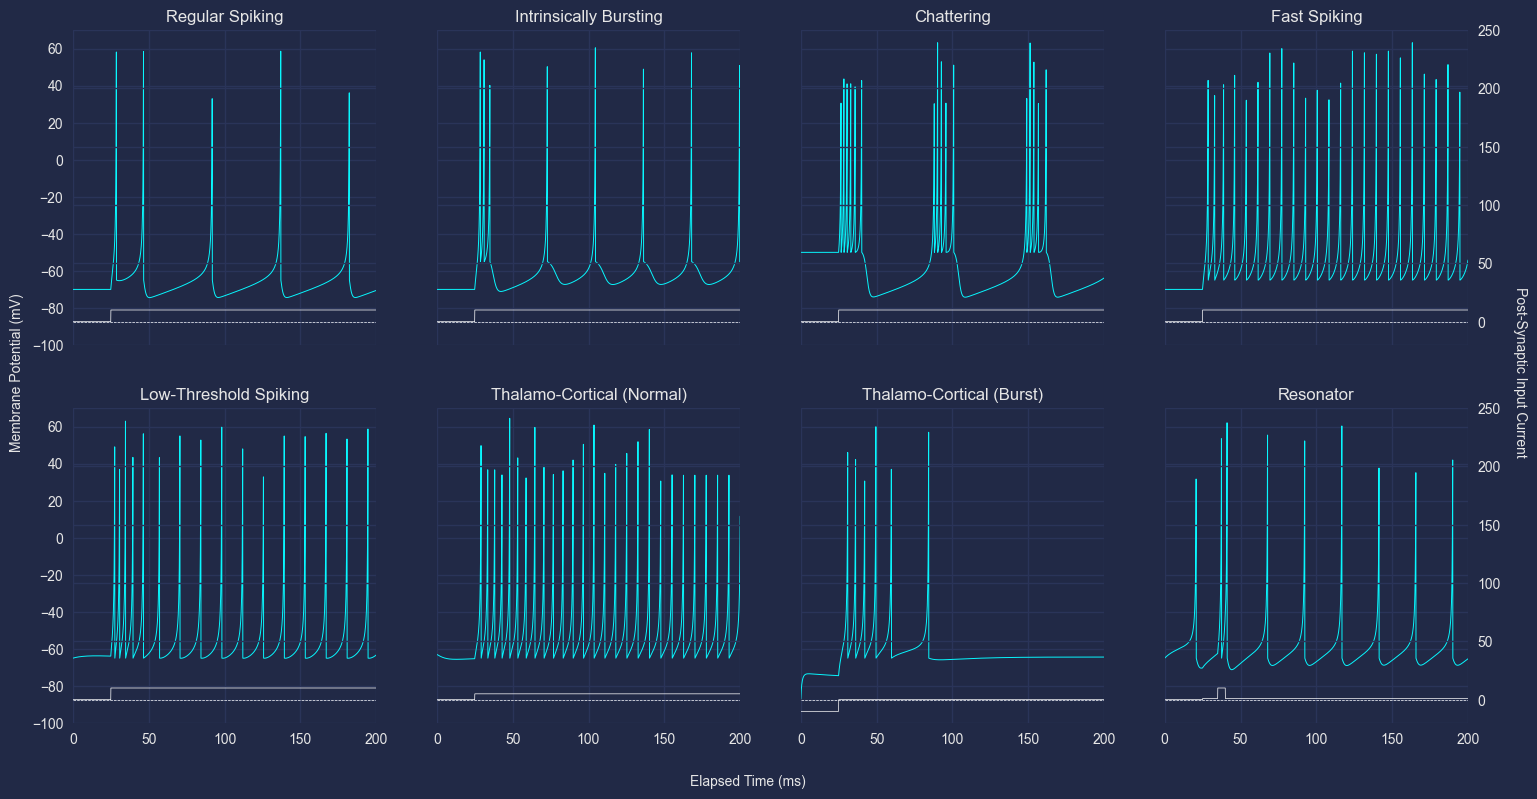

In [714]:
# Input current activations for each neuron
I: int = 10
D: int = 250
Iarray = lambda cur : np.concatenate([np.repeat(n, l) for n, l in cur]) 
activations: dict[NeuronClass, np.ndarray] = {
    NeuronClass.RS:     Iarray([(0, D), (I, SIMULATION_STEPS - D)]), 
    NeuronClass.IB:     Iarray([(0, D), (I, SIMULATION_STEPS - D)]), 
    NeuronClass.CH:     Iarray([(0, D), (I, SIMULATION_STEPS - D)]), 
    NeuronClass.FS:     Iarray([(0, D), (I, SIMULATION_STEPS - D)]), 
    NeuronClass.LTS:    Iarray([(0, D), (I, SIMULATION_STEPS - D)]), 
    NeuronClass.TCN:    Iarray([(0, D), (I * .5, SIMULATION_STEPS - D)]), 
    NeuronClass.TCB:    Iarray([(-I, D), (0, SIMULATION_STEPS - D)]),  
    NeuronClass.RZ:     Iarray([(0, D), (I * .1, 100), (I, 50), 
                                (I * .1, SIMULATION_STEPS - D - 150)]),  
}

# Perform simulations and aggregate results
df = neuron_map_simulation(NEURONS, activations)
neuron_map_simulation_plot(df)

### B. Improving the Resonator Behaviour

Currently, the resonator from the original model does not perform as expected. Upon further research, we can apply a time-quadratic sinusoidal current (scaled by $I=10$) in order to produce sub-threshold resonating behaviour as shown in the original paper. This is inspired from [this source](http://neuroinfo-cclolab.blogspot.com/2018/04/part-3-izhikevichs-simple-neurons.html) which also adopted a frequency factor $\omega$ although this simulation will only use the time $t$ to produce an input current with $I_{Resonator} = 10 \cdot \sin (\frac{t^2}{100})$.

Neuron Spiking Simulation: (Resonator): 100%|██████████| 9999/9999 [00:00<00:00, 94103.55it/s]


Text(0, 0.5, 'Post-Synaptic Input Current')

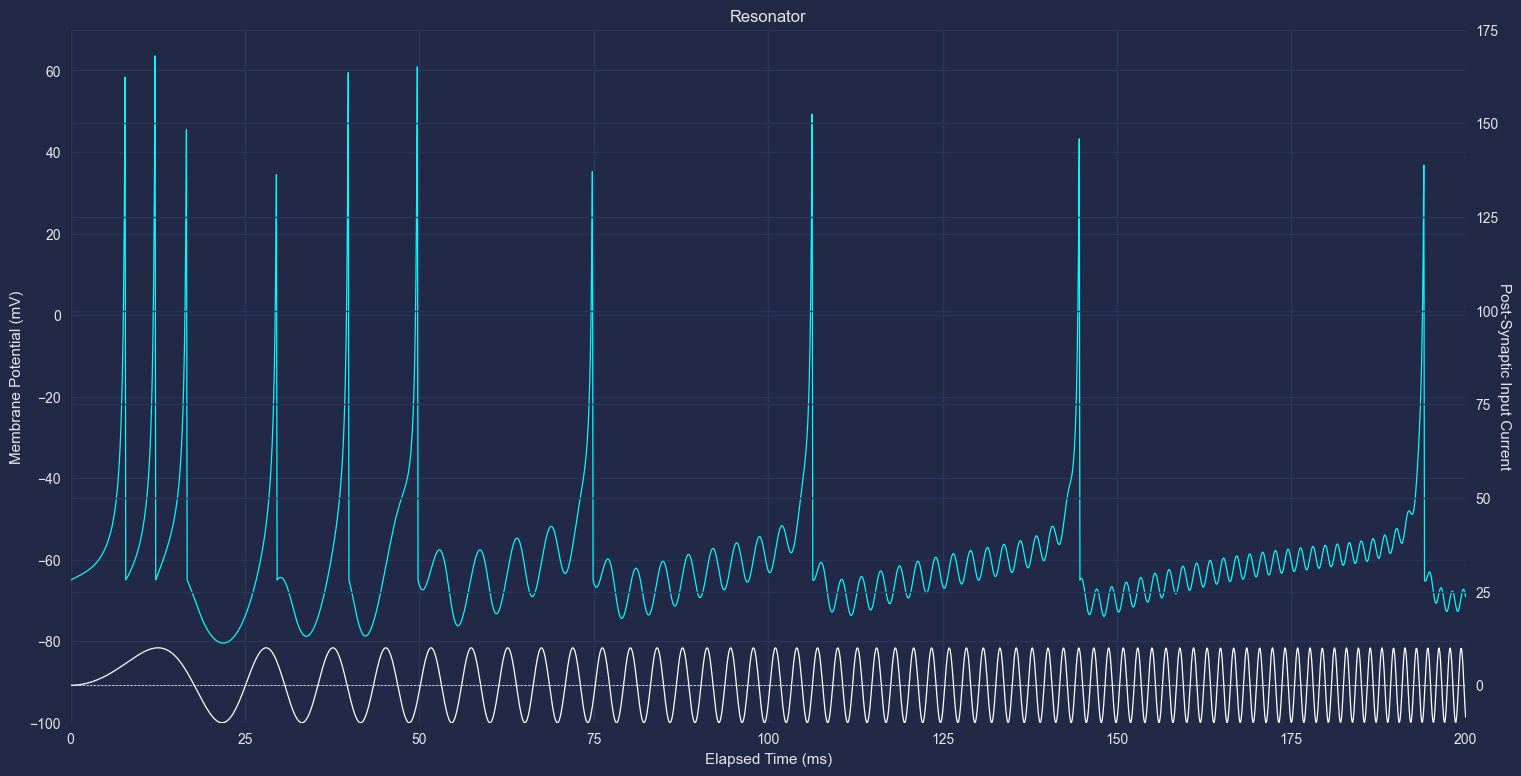

In [715]:
# Simulate the new resonator activations
resonator: Neuron = [neuron for neuron in NEURONS.values()][-1]
activation: np.ndarray = I * np.sin((np.arange(0, SIMULATION_STEPS, 1) / 100) ** 2)
res = NeuronSpikingSimulation.simulate(resonator, activation)
res["Neuron"] = resonator.dclass.value[0]
res["Type"] = resonator.dclass.value[1]
activations[NeuronClass.RZ] = activation

# Plot each line of interest
ax1 = plt.gca()
ax2 = plt.twinx()
sns.lineplot(ax=ax1, data=res, x="Time", y="Potential", linewidth=.9)
sns.lineplot(ax=ax2, data=res, x="Time", y="Current",   linewidth=.9, color="w")
ax2.plot([0, 1000], [0, 0], linestyle="--", linewidth=.50, color="w")
ax1.set_xlim((0, 200))
ax1.set_ylim((-100, 70))
ax1.set_xlim((0, 200))
ax2.set_ylim((-10, 175))
ax1.set_title(resonator.dclass.value[0])
ax1.set_xlabel("Elapsed Time (ms)")
ax1.set_ylabel("Membrane Potential (mV)")
ax2.set_ylabel("Post-Synaptic Input Current", va="center", rotation=270)

### C. Changing the Input Current

As an added experiment, the input current $I$ is changed to have a variable scale factor over some factor iterable in order to demonstrate how this affects the behaviour of the neuron spiking.

Neuron Spiking Simulation: (Regular Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 92776.64it/s]
Neuron Spiking Simulation: (Intrinsically Bursting): 100%|██████████| 9999/9999 [00:00<00:00, 95384.71it/s]
Neuron Spiking Simulation: (Fast Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 96469.24it/s]
Neuron Spiking Simulation: (Low-Threshold Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 95709.71it/s]
Neuron Spiking Simulation: (Thalamo-Cortical (Normal)): 100%|██████████| 9999/9999 [00:00<00:00, 96065.74it/s]
Neuron Spiking Simulation: (Thalamo-Cortical (Burst)): 100%|██████████| 9999/9999 [00:00<00:00, 97002.30it/s]
Neuron Spiking Simulation: (Regular Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 96827.39it/s]
Neuron Spiking Simulation: (Intrinsically Bursting): 100%|██████████| 9999/9999 [00:00<00:00, 97408.51it/s]
Neuron Spiking Simulation: (Fast Spiking): 100%|██████████| 9999/9999 [00:00<00:00, 97954.54it/s]
Neuron Spiking Simulation: (Low-Threshold Spiking): 100%|█

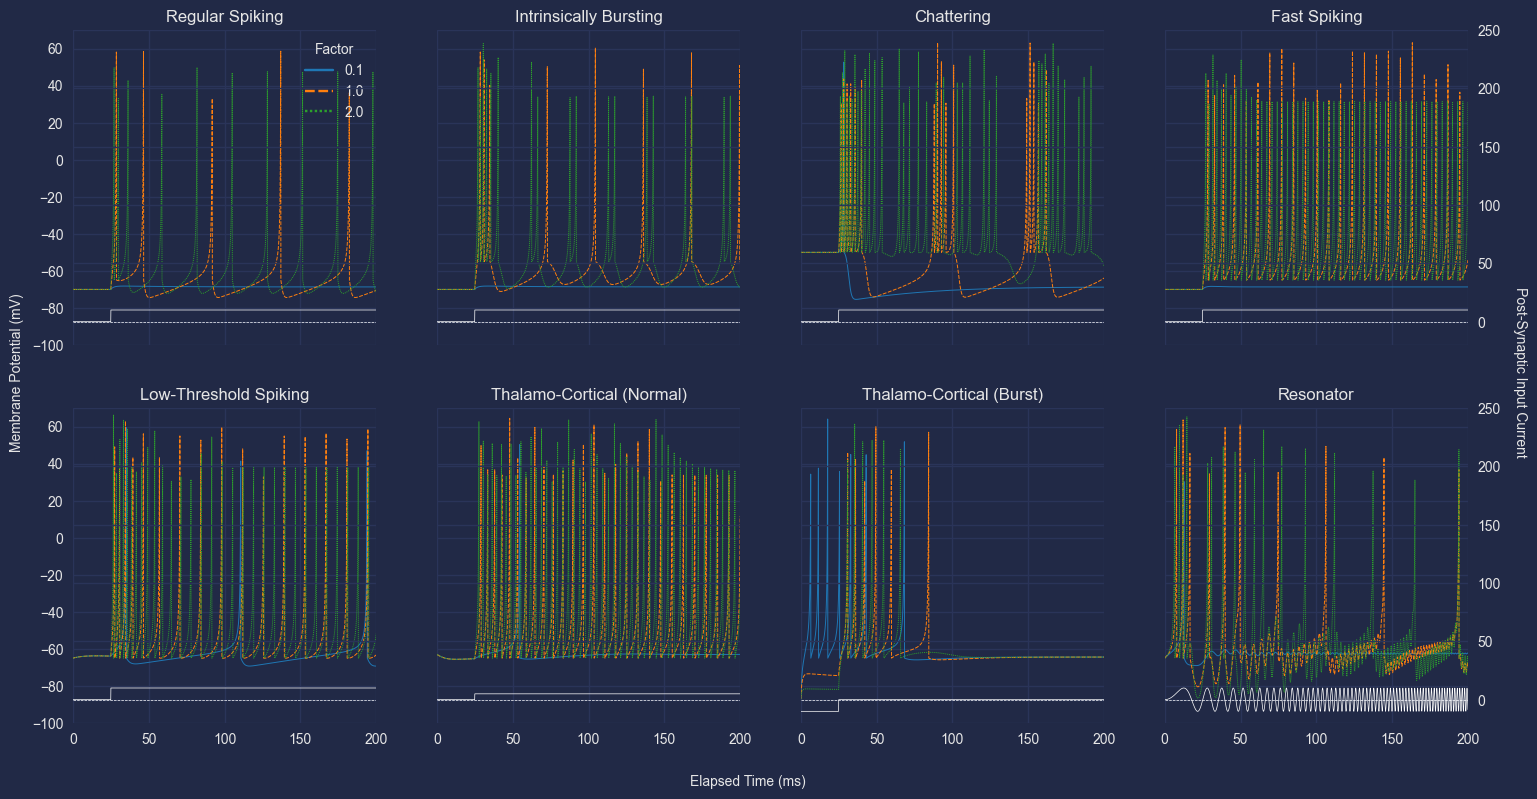

In [716]:
factors: list[float] = [0.1, 1, 2]
df = neuron_map_simulation(NEURONS, activations, factors=factors)
neuron_map_simulation_plot(df)

## Simulation 2: Cortex Synchronisation

The goal of this simulation is to mimic a collection of excitatory and inhibitory neurons and how spiking behaviours across this collection synchronises over a period of time. This is depicted as sinusoidal-like densities of neuron firings. The behaviour of this simulation is dependent on several constants under which assumptions are made. The conditions for this experiment uses the following values:

- $N_{excitatory} = 800$
- $N_{inhibitory} = 200$
- $a_{excitatory} = 0.02$
- $a_{inhibitory} = 0.02 + 0.08 \cdot \mathbb{U}[0,1]$
- $b_{excitatory} = 0.2$
- $b_{inhibitory} = 0.25 + 0.05 \cdot \mathbb{U}[0,1]$
- $c_{excitatory} = -65 + 15 \cdot \mathbb{U}[0,1]^2$
- $c_{inhibitory} = -65$
- $d_{excitatory} = -8 - 6 \cdot \mathbb{U}[0,1]^2$
- $d_{inhibitory} = -2$


Identical first-order differential equations for $\hat{v}$ and $\hat{u}$ to the previous simulation is used. Similar, neurons are given randomised activations from $\mathbb{U}[0,1]$ with different weightings and initial $\hat{v}=-65$ and $\hat{u}=-65 * b$. The threshold for neuron firing is kept consistent at $30mV$. The simulation is run with time-step delta 1ms where two 0.5ms steps are performed on each iteration.

### Constructing a Simulation

This simulation is constructed similarly to the previous experiment. This will allow variability for the number of neurons ($N_e, N_i$) and the input currents ($I_e, I_i$) to test how behaviours change with the different values.

In [717]:
class CortexSynchronisationSimulation:
    @staticmethod
    def simulate(
        Ne: int = 800,  
        Ni: int = 200,  
        ES: float = 0.5,
        IS: float = -1,
        simulation_total_ms: int = SIMULATION_TOTAL_TIME_MS,
    ) -> tuple[pd.DataFrame, pd.DataFrame]:
        """
        Perform a simulation of cortex activity to determine how neurons attain
        synchronisation over some period of time. A fixed 1ms time-step is used.

        Args:
            Ne (int, optional): Number of excitatory neurons. Defaults to 800.
            Ni (int, optional): Number of inhibitory neurons. Defaults to 200.
            ES (float, optional): Excitatory neuron current scale. Defaults to 0.5.
            IS (float, optional): Inhibitory neuron current scale. Defaults to -1.
            simulation_total_ms (int, optional): Simulation time in milliseconds. 
                Defaults to SIMULATION_TOTAL_TIME_MS.

        Returns:
            tuple[pd.DataFrame, pd.DataFrame]: Tuple of dataframes for respective result
                formats. (1) Contains timed firings by the neuron index, (2) stores
                the membrane potential sum for each time-step.
        """    
        
        # Create random excitatory and inhibitory neurons
        re = np.random.random(Ne)
        ri = np.random.random(Ni)

        # Initialise respective hyperparameter behaviours for each group
        a = np.concatenate([0.02 * np.ones(Ne), 0.02 + 0.08 * ri])
        b = np.concatenate([0.2  * np.ones(Ne), 0.25 - 0.05 * ri])
        c = np.concatenate([-65 + 15 * re ** 2, -65 * np.ones(Ni)])
        d = np.concatenate([8 - 6 * re ** 2, 2 * np.ones(Ni)])

        # Create random behaviours for the input current
        S = np.concatenate([ES * np.random.random((Ne + Ni, Ne)), 
                            IS * np.random.random((Ne + Ni, Ne + Ni))], axis=1)
        
        # Initialise update variables for the potential and recovery
        v = -65 * np.ones(Ne + Ni)
        u = b * v

        # Simulate for the given time period
        firings = None
        P = np.zeros(simulation_total_ms, dtype=np.float32)
        T = np.array([t for t in range(simulation_total_ms)])
        for t in tqdm.tqdm(T, desc="Cortex Synchronisation"):
            # Calculate the input current for this time-step
            I = np.concatenate([5 * np.random.normal(size=Ne), 
                                2 * np.random.normal(size=Ni)])
            
            # Isolate fired neurons and reset them
            fired = np.where(v >= 30)[0]
            timings = np.stack([t + 0 * fired, fired], axis=1)
            if firings is None:
                firings = timings
            else:
                firings = np.append(firings, timings, axis=0)
            v[fired] = c[fired]
            u[fired] = u[fired] + d[fired]

            # Update the potentials and recoveries for each neuron
            I = I + S[:,fired].sum(axis=1)
            v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I)
            v = v + 0.5 * (0.04 * v ** 2 + 5 * v + 140 - u + I) # Second step stable
            u = u + a * (b * v - u)   
            P[t] = np.sum(v)
        df_firings = pd.DataFrame(firings, columns=["Time (ms)", "Neuron Number"])
        df_potential = pd.DataFrame([T, P]).T
        df_potential.columns = ["Time (ms)", "Membrane Potential (mV)"]
        return df_firings, df_potential

In [718]:
def plot_cortex_synchronisation_simulation_ind(
    Ne: int = 800,  
    Ni: int = 200,  
    ES: float = 0.5,
    IS: float = -1,
    simulation_total_ms: int = SIMULATION_TOTAL_TIME_MS,
) -> pd.DataFrame:
    """
    Perform the simulation with different parameters and plot the results.

    Args:
        Ne (int, optional): Number of excitatory neurons. Defaults to 800.
        Ni (int, optional): Number of inhibitory neurons. Defaults to 200.
        ES (float, optional): Excitatory neuron current scale. Defaults to 0.5.
        IS (float, optional): Inhibitory neuron current scale. Defaults to -1.
        simulation_total_ms (int, optional): Simulation time in milliseconds. 
            Defaults to SIMULATION_TOTAL_TIME_MS.

    Returns:
        pd.DataFrame: Results from the simulation with column pair of the time of
            a neuron spiking and the respective neuron index.            
    """ 

    # Perform the simulation and plot the results
    df, _ = CortexSynchronisationSimulation.simulate(Ne, Ni, ES, IS, 
                                                     simulation_total_ms)
    plot = sns.jointplot(data=df, x="Time (ms)", y="Neuron Number", s=.75, 
                         marginal_kws=dict(bins=simulation_total_ms, fill=True), 
                         legend=False)
    plt.plot([0, simulation_total_ms], [Ne, Ne], linestyle="--")
    plot.ax_marg_y.remove()
    plot.fig.set_tight_layout(True)
    plot.fig.suptitle(
        f"Cortex Simulation ($N_e =$ {Ne}, $N_i =$ {Ni}, $I_e =$ {ES}, $I_i =$ {IS})")

### A. Baseline Cortex Synchronisation

The model below is a simple recreation of the expected behaviour with the given parameters. The simulation is plotted as the neuron index against the increasing time-scale. Banded columns of fired neurons show a slight synchronisation and the accompanying historgram shows slight spikes in consistent patterns.

Cortex Synchronisation:   0%|          | 0/1000 [00:00<?, ?it/s]

Cortex Synchronisation: 100%|██████████| 1000/1000 [00:00<00:00, 8049.51it/s]


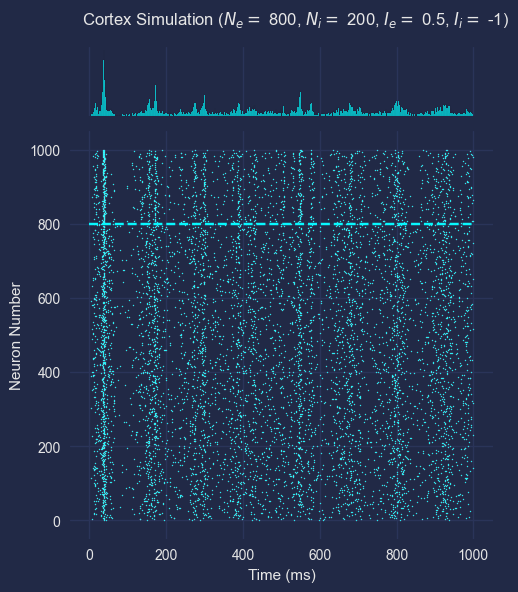

In [719]:
# Baseline model
plot_cortex_synchronisation_simulation_ind()

### B. Manipulating Neuron Counts and Input Currents

Now, changing values for $N_e, N_i, I_e, I_i$ is simulated to assess how this impacts the general behaviour of the cortex and whether synchronisation remains possible under these conditions. For easier comparison between different plot-wise neuron subpopulations, the plotting of membrane potential sums across all neurons to see if there is a distinct pattern matching any form of synchronisation.

In [720]:
# Setup a hyperparameter grid search
C: list[tuple[int, int]] = [(800, 200), (500, 500), (400, 600), (200, 800)]
ES: list[float] = [0.45, 0.5, 0.525, 0.55]
IS: list[float] = [-1.5, -1, -0.75, -0.5]

# Perform simulations for the hyperparamter grid
df = []
for c, e, i in itertools.product(C, ES, IS):
    assert c[0] + c[1] == 1000
    _, dat = CortexSynchronisationSimulation.simulate(c[0], c[1], e, i, 1000)
    dat["Neuron Counts ($N_e, N_i$)"] = f"({c[0]}, {c[1]})"
    dat["$I_e$"] = e
    dat["$I_i$"] = i
    df.append(dat)
df = pd.concat(df, axis=0)

Cortex Synchronisation:   0%|          | 0/1000 [00:00<?, ?it/s]

Cortex Synchronisation: 100%|██████████| 1000/1000 [00:00<00:00, 10932.15it/s]


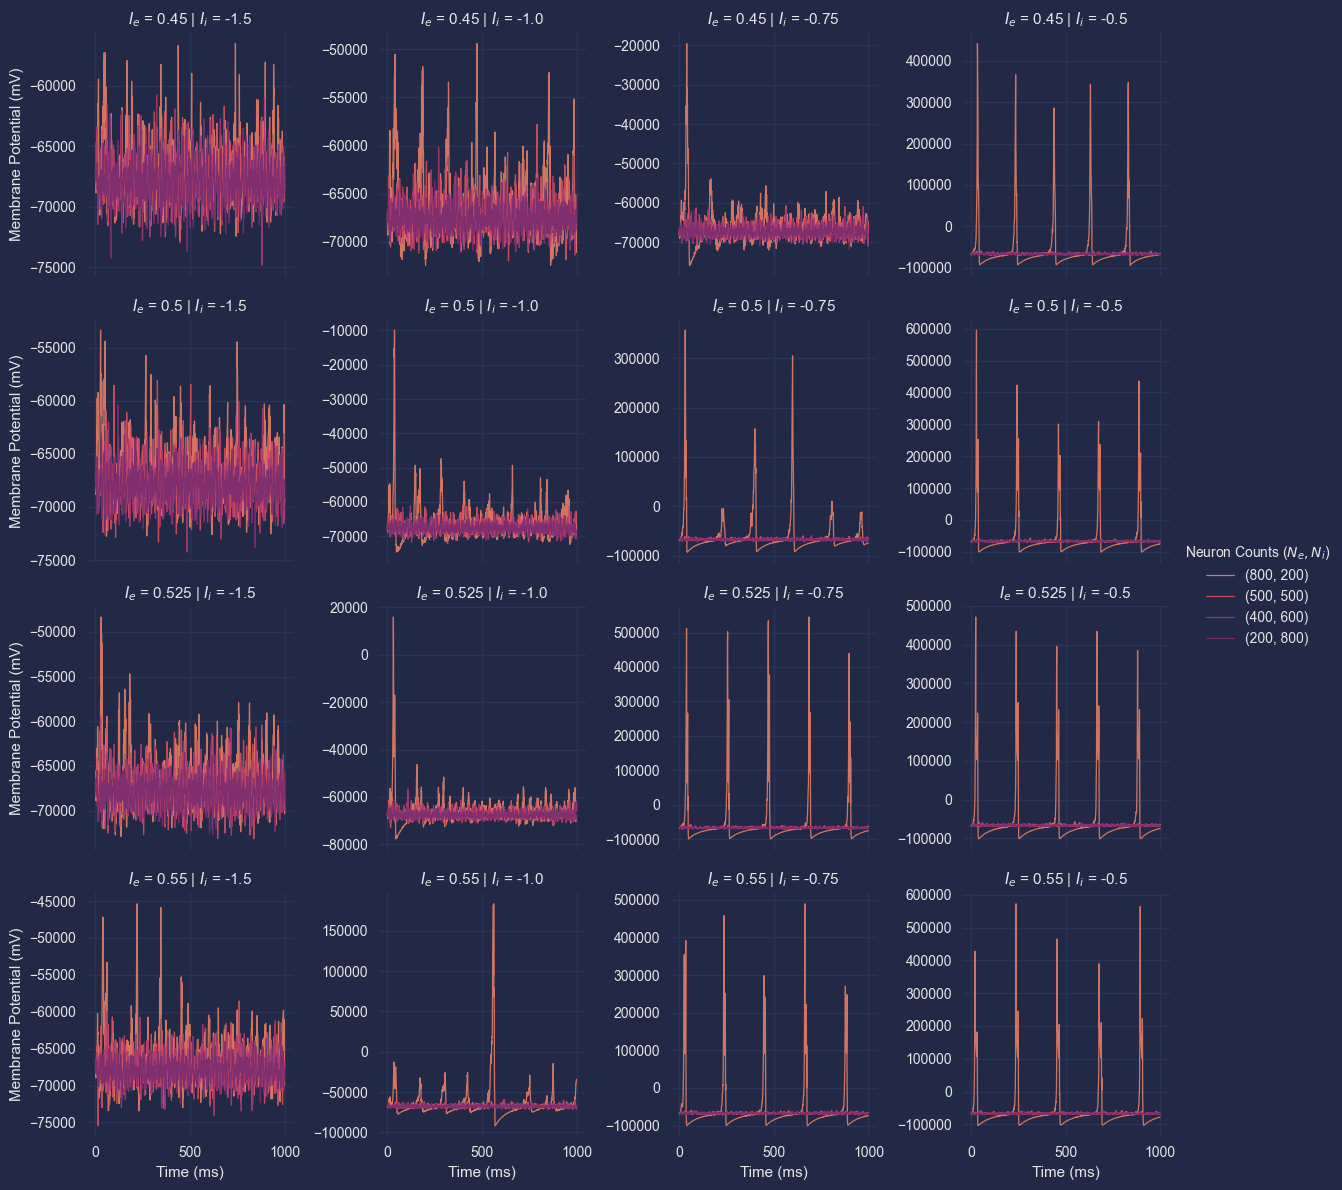

In [721]:
plot = sns.FacetGrid(data=df, row="$I_e$", col="$I_i$", 
                     hue="Neuron Counts ($N_e, N_i$)", sharex=True, sharey=False, 
                     legend_out=True, palette="flare")
plot.map(sns.lineplot, "Time (ms)", "Membrane Potential (mV)", linewidth=.9, alpha=0.9)
plot.add_legend()

## Simulation 3: Synapse Current Transfer

In order to demonstrate the movement of currents from one excitatory neuron to an inhibtatory neuron, a synapse is simulated by transferring a modified input current once the first neuron receives some stimulation which causes it to fire and send a current to the next neuron.

### Constructing the Simulation

The only simulation variables to consider are the particular neurons to be used, the step current which is used when a neuron fires and the input current jumps to the connected neuron, input currents for the excitatory neuron, and the decay rate (exponential) for the secondary neuron receiving a stimulus current.

In [722]:
class SynapseSimulation:
    NEURON_THRESHOLD: int = 30
    dvdt = NeuronSpikingSimulation.dvdt
    dudt = NeuronSpikingSimulation.dudt

    @staticmethod
    def simulate(
        neuron_a: Neuron,  
        neuron_b: Neuron,  
        step_current: float,
        current_a: np.ndarray,
        decay_rate: float = 0.9,
        simulation_total_ms: int = SIMULATION_TOTAL_TIME_MS,
    ) -> pd.DataFrame:
        """
        Perform a simulation of the transfer of current between synapse A and B. A fixed
        time-step of 1ms with two 0.5ms steps is performed for this simulation.

        Args:
            neuron_a (Neuron): Starting neuron receiving and input current.
            neuron_b (Neuron): Connected neuron for when firing occurs.
            step_current (float): Input current set for the receiving neuron.
            current_a (np.ndarray): Array of input currents to give to neuron_a.
            decay_rate (float, optional). Rate of deacy for neuron B received firing 
                current. Defaults to 0.9
            simulation_total_ms (int, optional): Simulation time in milliseconds. 
                Defaults to SIMULATION_TOTAL_TIME_MS.

        Returns:
            pd.DataFrame: Dataframe of simulation results. Columns correspond to the 
                simulation time, currents, and neuron membrane potentials.
        """    

        # Initialise containers for tracked values
        T = np.arange(0, simulation_total_ms)
        v_a = np.zeros(simulation_total_ms, dtype=np.float32)
        v_b = np.zeros(simulation_total_ms, dtype=np.float32)
        u_a = np.zeros(simulation_total_ms, dtype=np.float32)
        u_b = np.zeros(simulation_total_ms, dtype=np.float32)
        current_b = np.zeros(simulation_total_ms, dtype=np.float32)

        # Set initial values for the simulation
        v_a[0] = neuron_a.r
        v_b[0] = neuron_b.r
        u_a[0] = neuron_a.r * neuron_a.b
        u_b[0] = neuron_b.r * neuron_b.b

        # Simulate the time-steps
        for ind in T:
            # Get previous step values
            v_a_p = v_a[ind - 1]
            v_b_p = v_b[ind - 1]
            u_a_p = u_a[ind - 1]
            u_b_p = u_b[ind - 1]
            current_a_p = current_a[ind - 1]
            current_b_p = current_b[ind - 1]

            # Handle neuron A simulation behaviour
            if v_a_p >= SynapseSimulation.NEURON_THRESHOLD:
                # Capture neuron A firing
                v_a[ind] = neuron_a.c
                u_a[ind] = neuron_a.d + u_a_p
                # Update the second neuron to receive current stimulus
                current_b[ind] = step_current 
            else:
                # Normal neuron update function (stable two-step for membrane potential)
                v = v_a_p + 0.5 * SynapseSimulation.dvdt(v_a_p, u_a_p, current_a_p)
                v_a[ind] = v + 0.5 * SynapseSimulation.dvdt(v, u_a_p, current_a_p) 
                u_a[ind] = u_a_p + SynapseSimulation.dudt(neuron_a, v_a_p, u_a_p)

            # Handle neuron B simulation behaviour
            if v_b_p >= SynapseSimulation.NEURON_THRESHOLD:
                # Capture neuron B firing
                v_b[ind] = neuron_b.c
                u_b[ind] = neuron_b.d + u_b_p
            else:
                # Normal neuron update function (stable two-step for membrane potential)
                v = v_b_p + 0.5 * SynapseSimulation.dvdt(v_b_p, u_b_p, current_b_p)
                v_b[ind] = v + 0.5 * SynapseSimulation.dvdt(v, u_b_p, current_b_p) 
                u_b[ind] = u_b_p + SynapseSimulation.dudt(neuron_b, v_b_p, u_b_p)
                # Decay the current by some exp. rate (larger than small enough value)
                if current_b[ind] >= 0 and current_b_p != 0:
                    current_b[ind] += -decay_rate * current_b_p
                if current_b[ind] <= 0:
                    current_b[ind] = 0
        
        return pd.DataFrame({
            "Time": T,
            "Potential A": v_a, 
            "Potential B": v_b,
            "Current A": current_a, 
            "Current B": current_b,
        })
    
def plot_synapse_simulation(df: pd.DataFrame) -> None:
    """
    Plot the dataframe results of the synapse simulation. Include the current and 
    potentials for the two neurons to show firing behaviour to be in sync.

    Args:
        df (pd.DataFrame): Resulting dataframe from the simulation function.
    """    

    # Plot each of the lines for the potentials and currents
    ax1, ax2 = plt.gca(), plt.gca().twinx()
    p1 = sns.lineplot(df, x="Time", y="Potential A", label="Neuron A (Excitatory)", 
                      linewidth=3, ax=ax1)
    p2 = sns.lineplot(df, x="Time", y="Potential B", label="Neuron B (Inhibitory)", 
                      linewidth=3, ax=ax1)
    p3 = sns.lineplot(df, x="Time", y="Current A", label="Input Current A", 
                      linestyle=":", linewidth=2, ax=ax2)
    p4 = sns.lineplot(df, x="Time", y="Current B", label="Input Current B", 
                      linestyle=":", linewidth=2, ax=ax2)

    # Merge legend labels for each axis
    ax1_lines, ax1_labels = ax1.get_legend_handles_labels()
    ax2_lines, ax2_labels = ax2.get_legend_handles_labels()
    ax2.legend(ax1_lines + ax2_lines, ax1_labels + ax2_labels, loc="upper right")

    # Set plotting additions
    ax1.set_xlabel("Time (ms)")
    ax2.set_xlabel("")
    ax1.set_ylabel("Membrane Potential (mV)")
    ax2.set_ylabel("Input Current", rotation=270)
    ax1.set_ylim((-500, 1200))
    ax2.set_ylim((0, 250))
    ax1.set_xlim((0, 500))

### A. Baseline Simulation

As a more simple model, this can be implemented simply with a starting excitatory neuron (Regular spiking) into a inhibitory neuron (Fast spiking) with a step current of $I=50$ and alternating simulus current for the first neuron. The starting neuron potential noise is removed when adjusting to the starting conditions.

In [723]:
neuron_a = NEURONS[NeuronClass.RS]
neuron_b = NEURONS[NeuronClass.FS]
step_current = I * 5
current_a = np.tile(np.concatenate([np.repeat(0, 100), np.repeat(I, 50)]), 10)[:1000]
df = SynapseSimulation.simulate(neuron_a, neuron_b, step_current, current_a)
df = df[df.Time >= 10]

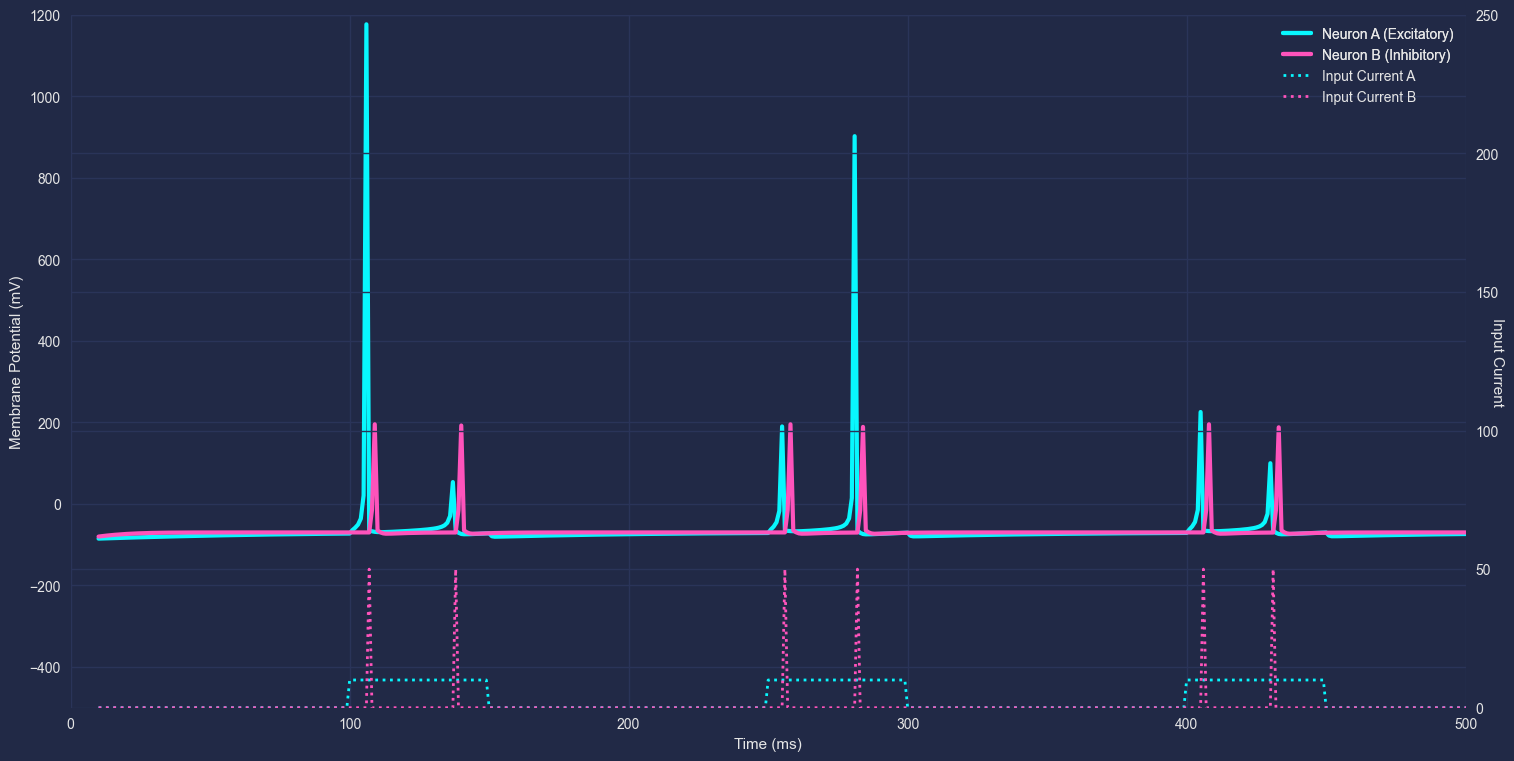

In [724]:
plot_synapse_simulation(df)